In [2]:
# !pip install -U tensorflow-addons
# !pip install tensorflow-addons


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
print("All major imports added.")

All major imports added.


In [3]:
num_classes = 100     # Number of different classes of images that we'll be looking for.
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 #The number of transformer blocks that we will stack together for deep learning.
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
print(f"This will result in {num_patches} patches per image of {image_size}x{image_size} divided into patches of {patch_size}x{patch_size}.");
print(f"Each image will be encoded into {num_patches} vectors that are {projection_dim} long.")

This will result in 144 patches per image of 72x72 divided into patches of 6x6.
Each image will be encoded into 144 vectors that are 64 long.


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Original Image size: 32 X 32
Resized Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


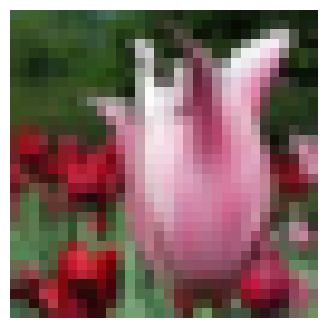

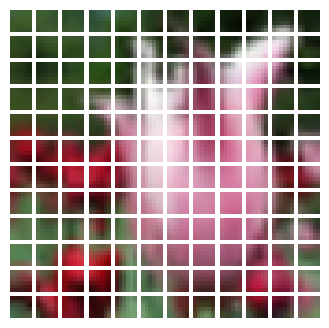

In [12]:
plt.figure(figsize=(4, 4))
# image = imgs
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Original Image size: {image.shape[0]} X {image.shape[1]}")
print(f"Resized Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [22]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        print(f"frame dims: {patch}")
        print(f"positions dims: {positions}")
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [23]:

inputs = tf.keras.layers.Input(shape=input_shape)
# Augment data. (This will do the image preparation such as resizing it.)
augmented = data_augmentation(inputs) 
# Create patches.
patches = Patches(patch_size)(augmented)
# Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
print(f"Shape of each Patch:  {patches.shape}")
print(f"Shape of Encoded Patches:  {encoded_patches.shape}")
print(f"Encoded Patches:  {encoded_patches}")

frame dims: Tensor("Placeholder:0", shape=(None, None, 108), dtype=float32)
positions dims: Tensor("patch_encoder_5/range:0", shape=(144,), dtype=int32)
Shape of each Patch:  (None, None, 108)
Shape of Encoded Patches:  (None, 144, 64)
Encoded Patches:  KerasTensor(type_spec=TensorSpec(shape=(None, 144, 64), dtype=tf.float32, name=None), name='patch_encoder_5/add:0', description="created by layer 'patch_encoder_5'")


In [1]:
def create_vit_classifier(shape_of_input_images, num_target_classes):
    inputs = tf.keras.layers.Input(shape=shape_of_input_images)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    print(f"Encoded patches shape: {encoded_patches.shape}")

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_target_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
# Compile, train, and evaluate the Model

In [17]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_filepath = "/TrainedModel/model_epoch-{epoch:02d}_acc-{val_accuracy:.4f}.hdf5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier(input_shape, num_classes)
vit_classifier.summary()

In [19]:
# with tf.device('/gpu:1'):
#     history = run_experiment(vit_classifier)    

Epoch 1/100
176/176 [==============================] - 1930s 11s/step - loss: 4.4619 - accuracy: 0.0491 - top-5-accuracy: 0.1681 - val_loss: 3.8752 - val_accuracy: 0.1156 - val_top-5-accuracy: 0.3214
Epoch 2/100
176/176 [==============================] - 1880s 11s/step - loss: 3.9503 - accuracy: 0.0979 - top-5-accuracy: 0.2927 - val_loss: 3.5791 - val_accuracy: 0.1548 - val_top-5-accuracy: 0.4144
Epoch 3/100
176/176 [==============================] - 1974s 11s/step - loss: 3.6877 - accuracy: 0.1348 - top-5-accuracy: 0.3690 - val_loss: 3.3673 - val_accuracy: 0.1928 - val_top-5-accuracy: 0.4644
Epoch 4/100
176/176 [==============================] - 1986s 11s/step - loss: 3.4927 - accuracy: 0.1687 - top-5-accuracy: 0.4253 - val_loss: 3.2053 - val_accuracy: 0.2208 - val_top-5-accuracy: 0.5094
Epoch 5/100
176/176 [==============================] - 1983s 11s/step - loss: 3.3494 - accuracy: 0.1903 - top-5-accuracy: 0.4658 - val_loss: 3.0847 - val_accuracy: 0.2516 - val_top-5-accuracy: 0.5496


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /tmp/checkpoint

In [ ]:
history = run_experiment(vit_classifier)  

In [22]:
# vit_classifier.evaluate(x_test, y_test)

accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

 80/313 [======>.......................] - ETA: 1:50 - loss: 2.3181 - accuracy: 0.4750 - top-5-accuracy: 0.7605